In [1]:
from lib import Augmentation_methods
from lib import data_preparation

import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output

2023-01-09 22:46:28.448192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"

# BASEDIR = pathlib.Path('/store/projects/fallki/')
# FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

In [4]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

In [5]:
#To obtain the dummy data
dummy_lab_data = data_preparation.fake_lab_data()
dummy_data = dummy_lab_data[0]
dummy_dataframe =pd.DataFrame(dummy_data,columns=['z'])

/home/ing2146/Final/SNEHA/lib/data_preparation.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]
/home/ing2146/Final/SNEHA/lib/data_preparation.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_fake_dummy_Data = np.array(df_fake_dummy_Data)


In [7]:
index_list = []
for index,row in dummy_dataframe.iterrows():
    if row["z"][0] < 0:
        index_list.append(index)

dummy_data_df = dummy_dataframe.drop(index_list)

In [8]:
dummy_data_df.reset_index(drop=True, inplace=True)

#### Augmentation of dummy events

In [9]:
augmented_dummy = []

for i, event in enumerate(dummy_data_df.to_numpy().ravel()): 
    
    #Jittering
    Noise_dummy = Augmentation_methods.add_white_noise(event, 0.15) 
    augmented_dummy.append(Noise_dummy)
    
    #Jittering
    Noise_dummy1 = Augmentation_methods.add_white_noise(event, 0.12) 
    augmented_dummy.append(Noise_dummy1)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.08) 
    augmented_dummy.append(Noise_dummy2)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.05) 
    augmented_dummy.append(Noise_dummy2)
    
    #Magnitude Warping
    magnitude_warped_dummy =  Augmentation_methods.magnitudewarping(event,0.1, 20) 
    augmented_dummy.append(magnitude_warped_dummy[1])
    
    #Magnitude Warping
    magnitude_warped_dummy1 =  Augmentation_methods.magnitudewarping(event,0.1, 15) 
    augmented_dummy.append(magnitude_warped_dummy1[1])
    
    #Magnitude Warping
    magnitude_warped_dummy2 =  Augmentation_methods.magnitudewarping(event,0.1, 10) 
    augmented_dummy.append(magnitude_warped_dummy2[1])
    
    #Window Warping
    window_warped_dummy = Augmentation_methods.windowWarp(event, window_ratio=0.1, scales=[0.5, 2.]) 
    augmented_dummy.append(window_warped_dummy)
    
    #Jittering + Magnitude warping
    curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(event, 0.50)),0.1, 10)
    augmented_dummy.append(jittered_magnitude_warped_dummy)
    
    #Jittering + window warping
    Jittered_window_warped_dummy = Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(event, 0.50)), window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(Jittered_window_warped_dummy)
    
    #magnitude warping + window warping
    mag_warped  =  Augmentation_methods.magnitudewarping(event,0.1, 10)
    mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(mag_window_warped_dummy)
          
    
augmented_dummy_array = np.array(augmented_dummy)    

/tmp/ipykernel_1403435/2480421356.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_dummy_array = np.array(augmented_dummy)


In [10]:
augmented_dummy_array_df =pd.DataFrame(augmented_dummy_array,columns=['z'])

## Data Preparation

### Augmented data 

In [11]:
M = []
for i in range(len(augmented_dummy_array_df)):
    M.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(augmented_dummy_array_df.z[i]),
              "spectrum": SignalToSpectrum(augmented_dummy_array_df.z[i])})
augmented_df = pd.DataFrame.from_dict(M)

In [12]:
# normalize the spectrum to facilitate training 
augmented_df["normalizedSpectrum"] = augmented_df["spectrum"] / augmented_df["spectrum"].map(np.max).max()

# shuffle the final dataframe
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

### Dummy events(k) for test

In [13]:
R = []
for i in range(len(dummy_data_df)):
    R.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(dummy_data_df.z[i]),
              "spectrum": SignalToSpectrum(dummy_data_df.z[i])})
test_part_df = pd.DataFrame.from_dict(R)

In [14]:
# normalize the spectrum to facilitate training
test_part_df["normalizedSpectrum"] = test_part_df["spectrum"] / test_part_df["spectrum"].map(np.max).max()

### Positive events

In [15]:
L = []
for (teensy, event, run, rep), ss in df_fake.groupby(["teensy", "experiment", "run", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": SignalToSpectrum(ss["z"])})
df = pd.DataFrame.from_dict(L)
df.drop('run', inplace=True, axis=1)

In [16]:
# normalize the spectrum to facilitate training
df["normalizedSpectrum"] = df["spectrum"] / df["spectrum"].map(np.max).max()

In [17]:
# Dropping dummy events from the dataframe
df_drop = []
df_drop = df.drop(df[(df['event'] == "Dummy")].index)

### Append dataframe for training

In [18]:
final_df = []
final_df = df_drop.append(augmented_df)

/tmp/ipykernel_1403435/2286985223.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = df_drop.append(augmented_df)


In [19]:
#shuffle the final dataframe
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [20]:
final_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16055,"[[[194.30386703897017], [1.9848227140069479], ...","[[[0.4673882257753442], [0.004774391683065433]..."
1,Getränkeflasche,0,16004,"[[[218.47277029254684], [0.287950435470122], [...","[[[0.3193630643509709], [0.0004209253781594579..."
2,Dummy,1,15955,"[[[220.29149258495568], [0.4680485129022182], ...","[[[0.529900158147828], [0.001125867268397087],..."
3,Dummy,1,15991,"[[[220.46577640416118], [0.8751818208770009], ...","[[[0.5303193891506957], [0.002105206060610705]..."
4,Dummy,1,15963,"[[[220.28510693886258], [0.17190195436130254],...","[[[0.5298847977958012], [0.0004135015462153883..."
...,...,...,...,...,...
1728,Dummy,1,15999,"[[[218.15268842214854], [0.1255410697461989], ...","[[[0.5247553717976168], [0.0003019827589887665..."
1729,2 Bücher,0,16038,"[[[217.99728773596414], [0.29198320415374085],...","[[[0.3186680048883553], [0.0004268204714605341..."
1730,Stuhl kippt,0,16024,"[[[220.3931276864514], [0.11757535191403377], ...","[[[0.32217023899861774], [0.000171871417335575..."
1731,Wasserkasten,0,16033,"[[[218.0403537019797], [0.44378366340576975], ...","[[[0.31873095863246514], [0.000648722083142832..."


### Input and target split for train and test

#### Input and target for Train

In [21]:
X = np.stack(final_df["normalizedSpectrum"].to_list())
y = final_df["istSturz"].to_numpy()

#### Input and target for test

In [22]:
X_tst = np.stack(test_part_df["normalizedSpectrum"].to_list())
y_tst = test_part_df["istSturz"].to_numpy()

### Model

#### Cross-validation

In [23]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [25]:
# Model configuration
#batch_size = 50
loss_function = "binary_crossentropy"
no_epochs = 75
optimizer = "adam"
verbosity = 0
num_folds = 5

In [26]:
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [27]:
# defind array fot ROC, Precision-recall curve and confusion martrix
roc_values = []
precision_recall_values = []
auc = []
confusion_matrices = []

In [28]:
# Define the K-fold Cross Validator
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skfold.split(X, y):
    mdl = Sequential()
    mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
    mdl.add(MaxPooling2D((1, 4)))
    mdl.add(Flatten())
    mdl.add(Dense(1,activation="sigmoid"))
    #mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #mdl.summary()

    # Compile the model
    mdl.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])


      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = mdl.fit(X[train], y[train],
                  epochs=no_epochs,
                  verbose=verbosity)

    # Generate generalization metrics
    scores = mdl.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {mdl.metrics_names[0]} of {scores[0]}; {mdl.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Confusion Matrix
    # Predict the labels for the test set
    y_pred = mdl.predict(X[test,])
    
    # Convert the predicted labels to a binary form
    y_pred_binary = np.where(y_pred > 0.10, 1, 0)
    
    
    # ROC AND PRECISION RECALL VALUES
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_values.append((fpr, tpr,thresholds))
    
    
    precision, recall, thresholds_1 = precision_recall_curve(y[test], y_pred)
    precision_recall_values.append((precision, recall,thresholds_1)) 
    
    auc = roc_auc_score(y[test], y_pred)
     
    #confusion matrix
    confusion_matrices.append(confusion_matrix(y[test], y_pred_binary))


    # Increase fold number
    fold_no = fold_no + 1

2023-01-09 22:51:33.410562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.03199955075979233; accuracy of 98.27089309692383%
11/11 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.00876427162438631; accuracy of 99.71181750297546%
11/11 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.006529974285513163; accuracy of 100.0%
11/11 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.005606756545603275; accuracy of 100.0%
11/11 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 5 ...
Score for fol

In [29]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.03199955075979233 - Accuracy: 98.27089309692383%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.00876427162438631 - Accuracy: 99.71181750297546%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.006529974285513163 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.005606756545603275 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.013570837676525116 - Accuracy: 99.71098303794861%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.53873872756958 (+- 0.6469282542894123)
> Loss: 0.013294278178364038
------------------------------------------

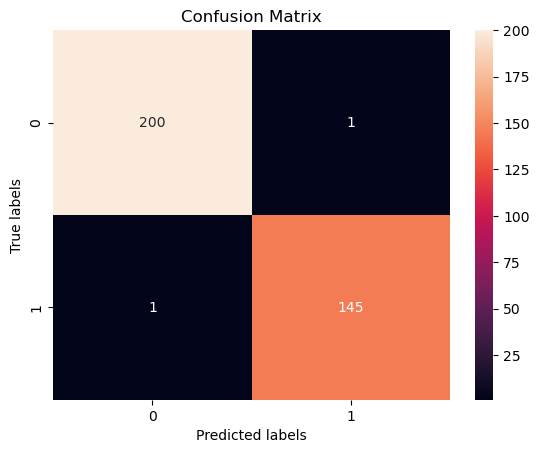

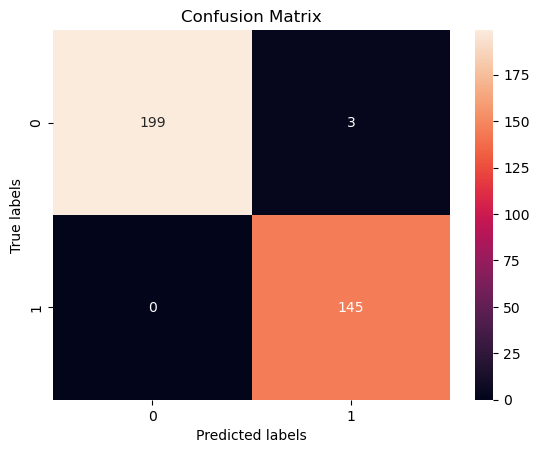

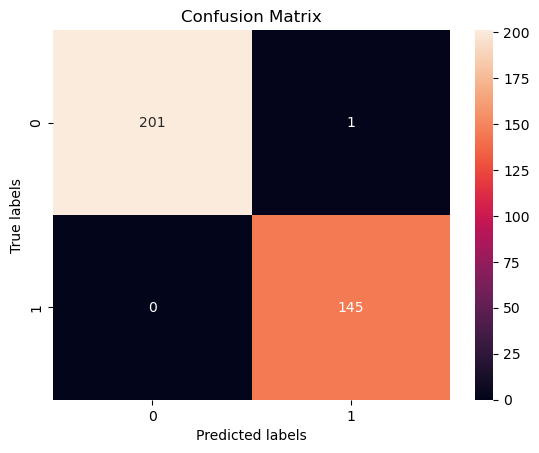

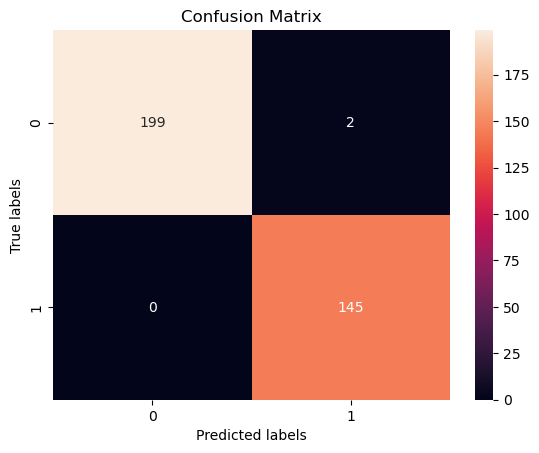

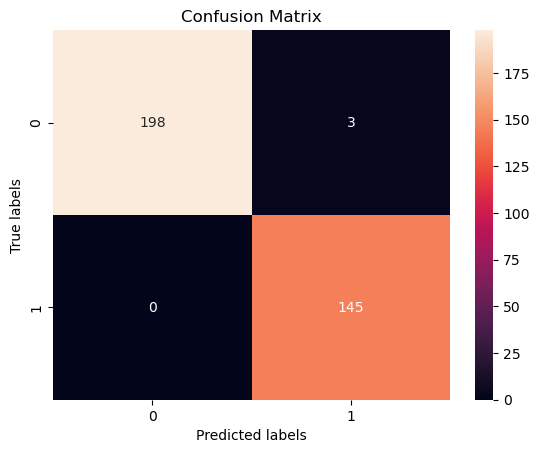

In [30]:
# Plot the confusion matrix values for each fold on the same graph
for cm in confusion_matrices:
    ax= pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    pyplot.show() 

# Show the plot
plt.show()

In [31]:
pyplot.rcParams.update({'font.size': 8})

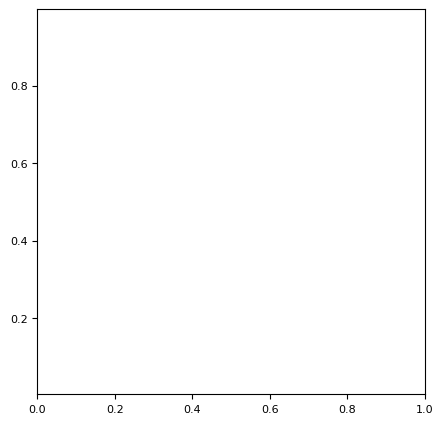

In [32]:
tprs = []
base_fpr = np.linspace(0, 1, 101)
pyplot.figure(figsize=(5, 5))
pyplot.axes().set_aspect('equal', 'datalim')

For fold 1 optimal Threshold=0.201903, G-Mean=0.997
For fold 2 optimal Threshold=0.820365, G-Mean=1.000
For fold 3 optimal Threshold=0.695168, G-Mean=1.000
For fold 4 optimal Threshold=0.894621, G-Mean=1.000
For fold 5 optimal Threshold=0.287950, G-Mean=0.998
mean Threshold=1.000000, G-Mean=0.994


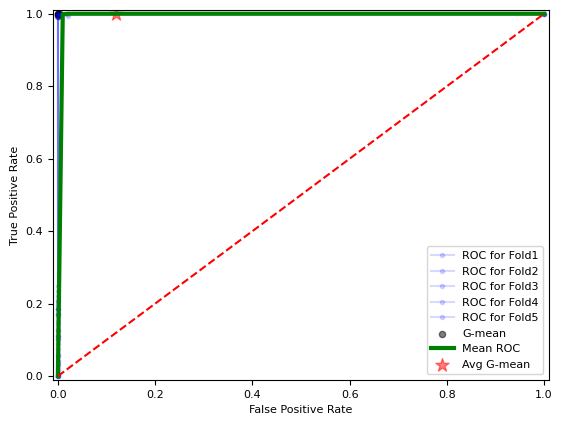

In [33]:
# Plot the ROC and precision-recall values for each fold on the same graph
tprs = []

# Calculate the mean values of FPR and TPR for the ROC curve
mean_fpr = sum(fpr[i] for i in range(len(roc_values))) / len(roc_values)
mean_tpr = sum(tpr[i] for i in range(len(roc_values))) / len(roc_values)

# Calculate the mean values of precision and recall for the precision-recall curve
mean_precision = sum(precision[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)
mean_recall = sum(recall[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)

i = 1
j = 1
    
# ROC CURVE
for fpr, tpr,thresholds in roc_values:
    
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('For fold '  +str(i), 'optimal Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr,'b', alpha=0.15, marker='.', label='ROC for Fold' +str(i))
    
    tpr_new = np.interp(base_fpr, fpr, tpr)
    tpr_new[0] = 0.0
    tprs.append(tpr_new)
    
   
    if i == num_folds:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black', label='G-mean')
        pyplot.legend()
    else:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black')  
        pyplot.legend()
        
    i = i + 1
     
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


gmeans_new = sqrt(mean_tprs * (1-base_fpr))
# locate the index of the largest g-mean
iy = argmax(gmeans_new)
print('mean Threshold=%f, G-Mean=%.3f' % (thresholds[iy], gmeans_new[iy]))

pyplot.plot(base_fpr, mean_tprs, 'g',linewidth=3.0, label='Mean ROC')
pyplot.scatter(base_fpr[ix], mean_tprs[ix],s=100,alpha=0.5, marker="*", color='Red', label='Avg G-mean')
pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([-0.01, 1.01])
pyplot.ylim([-0.01, 1.01])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.legend()
pyplot.show()



In [34]:
prc = []
base_recall = np.linspace(0, 1, 101)

For fold 1 Best Threshold=0.201903, F-Score=0.997
For fold 2 Best Threshold=0.820365, F-Score=1.000
For fold 3 Best Threshold=0.695168, F-Score=1.000
For fold 4 Best Threshold=0.894621, F-Score=1.000
For fold 5 Best Threshold=0.287950, F-Score=0.997


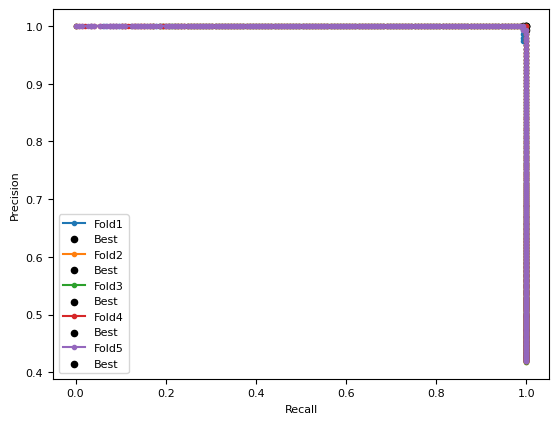

In [35]:
ix = 0 
j = 1
# PRECISION RECALL CURVE
for precision, recall, thresholds_1 in precision_recall_values:
    
     # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('For fold '  +str(j),'Best Threshold=%f, F-Score=%.3f' % (thresholds_1[ix], fscore[ix]))

    pyplot.plot(recall, precision, marker='.', label='Fold' + str(j))
    
    
    pyplot.scatter(recall[ix], precision[ix],s=20, marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    
    j = j + 1


# Show the plot
pyplot.show()

In [36]:
ypred = mdl.predict(X_tst).ravel()
threshold = 0.87
pd.crosstab(test_part_df['event'], ypred >= threshold)

3/3 [==============================] - 0s 3ms/step


col_0,True
event,
Dummy,66
